In [1]:
# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 감성분석 5단계 분류 모델

- 0 : '부정적'
- 1 : '약간 부정적'
- 2 : '중립적'
- 3 : '약간 긍정적'
- 4 : '긍정적'


In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
# import os

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from bs4 import BeautifulSoup
import re

from tqdm import tqdm

In [3]:
from tqdm import tqdm
from tensorflow.keras.utils import to_categorical
import random
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense,Dropout,Embedding,LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Bidirectional

tf.random.set_seed(123)
random.seed(123)

In [4]:
train = pd.read_csv('drive/MyDrive/data/train.tsv',sep='\t')
print(train.shape)

(156060, 4)


In [5]:
def clean_sentences(df):
  review = []

  for sent in tqdm(df['Phrase']):
    # remove html content
    # review_text = BeautifulSoup(sent).get_text() 

    review_text = re.sub('[^a-zA-Z]',' ',sent) 
    words = word_tokenize(review_text.lower()) # 토큰화
    lemma_words = [lemmatizer.lemmatize(i) for i in words] # 현재, 과거형등을 원형으로(표제어)
    review.append(lemma_words)

  return review

In [6]:
# nltk.download('punkt') pc 환경
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [7]:
train_sentence = clean_sentences(train)

100%|██████████| 156060/156060 [00:18<00:00, 8270.44it/s]


In [8]:
target = train.Sentiment.values
target.shape

(156060,)

In [9]:
y_target = to_categorical(target)
num_classes = y_target.shape[1]
print(num_classes)

5


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


2    79582
3    32927
1    27273
4     9206
0     7072
Name: Sentiment, dtype: int64


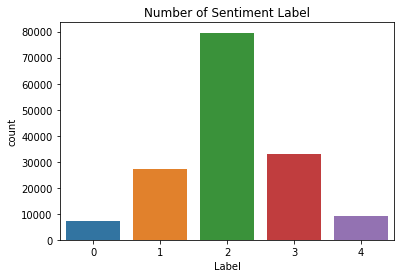

In [10]:
# Y 레이블의 분포
print(train['Sentiment'].value_counts())
sns.countplot(train['Sentiment'])
plt.xlabel('Label')
plt.title('Number of Sentiment Label')
plt.show()

In [11]:
# stratify=y_target: y값의 분포를 원본과 동일한 비율로 split시킴
X_train, X_val, y_train, y_val = train_test_split(train_sentence, y_target, test_size = 0.2, stratify = y_target)

In [12]:
unique_words = set()
len_max = 0

for sent in tqdm(X_train):
  unique_words.update(sent)
  if(len_max < len(sent)):
    len_max = len(sent)

print('\n',len(unique_words))
print(len_max)

100%|██████████| 124848/124848 [00:00<00:00, 781454.72it/s]


 13734
48


In [13]:
tokenizer = Tokenizer(num_words=len(list(unique_words)))
tokenizer.fit_on_texts(list(X_train))

X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)

X_train = sequence.pad_sequences(X_train,maxlen=len_max)
X_val = sequence.pad_sequences(X_val,maxlen=len_max)

print(X_train.shape, X_val.shape)

(124848, 48) (31212, 48)


## 학습 모델 구현

In [14]:
early_stopping = EarlyStopping(min_delta = 0.001, mode = 'max', monitor='val_acc', patience = 2)
callback = [early_stopping]

model = Sequential([
    Embedding(len(list(unique_words)),300,input_length=len_max),
    LSTM(128,dropout=0.5, recurrent_dropout=0.0,return_sequences=True),
    LSTM(64,dropout=0.5, recurrent_dropout=0.0,return_sequences=False),
    Dense(100,activation='relu'),
    Dropout(0.5),
    Dense(num_classes,activation='softmax')
    ])

model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.005),metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 48, 300)           4120200   
_________________________________________________________________
lstm (LSTM)                  (None, 48, 128)           219648    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 100)               6500      
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 505       
Total params: 4,396,261
Trainable params: 4,396,261
Non-trainable params: 0
______________________________________________

In [15]:
history=model.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=6, batch_size=256, verbose=1,
                  callbacks=callback)

Epoch 1/6
488/488 [==============================] - 33s 67ms/step - loss: 1.0265 - accuracy: 0.5868 - val_loss: 0.8475 - val_accuracy: 0.6517
Epoch 2/6
488/488 [==============================] - 31s 64ms/step - loss: 0.8073 - accuracy: 0.6701 - val_loss: 0.8117 - val_accuracy: 0.6702
Epoch 3/6
488/488 [==============================] - 31s 64ms/step - loss: 0.7347 - accuracy: 0.6973 - val_loss: 0.7934 - val_accuracy: 0.6763
Epoch 4/6
488/488 [==============================] - 31s 64ms/step - loss: 0.6914 - accuracy: 0.7141 - val_loss: 0.8186 - val_accuracy: 0.6753
Epoch 5/6
488/488 [==============================] - 31s 63ms/step - loss: 0.6627 - accuracy: 0.7241 - val_loss: 0.8305 - val_accuracy: 0.6723
Epoch 6/6
488/488 [==============================] - 31s 64ms/step - loss: 0.6429 - accuracy: 0.7336 - val_loss: 0.8518 - val_accuracy: 0.6716


In [16]:
accr = model.evaluate(X_val,y_val)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

976/976 [==============================] - 5s 5ms/step - loss: 0.8518 - accuracy: 0.6716
Test set
  Loss: 0.852
  Accuracy: 0.672
